In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt


### Import Packages 

In [2]:
import numpy as np
import pandas as pd
import time
import string
import re
import math

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, TweedieRegressor,HuberRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error as mse


import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

import kerastuner as kt

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.io import curdoc, show, output_notebook
output_notebook()

import nltk
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import pos_tag
stop_words = stopwords.words('english')

import spacy
nlp = spacy.load('en_core_web_lg')
from spacy import displacy

import transformers
from transformers import BertTokenizer, TFBertModel, RobertaTokenizer, TFRobertaModel


Loading BokehJS ...

In [3]:
df_train = pd.read_csv('/kaggle/input/commonlitreadabilityprize/train.csv')
df_test = pd.read_csv('/kaggle/input/commonlitreadabilityprize/test.csv')
df_submission = pd.read_csv('/kaggle/input/commonlitreadabilityprize/sample_submission.csv')

print(" Training dataset shape : " + str(df_train.shape))
print(" Testing dataset shape : " + str(df_test.shape))

 Training dataset shape : (2834, 6)
 Testing dataset shape : (7, 4)


In [4]:
df_train

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [5]:
df_test

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at ..."
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,Milka and John are playing in the garden. Her ...


In [6]:
df_submission

,id,target
0,c0f722661,0.0
1,f0953f0a5,0.0
2,0df072751,0.0
3,04caf4e0c,0.0
4,0e63f8bea,0.0
5,12537fe78,0.0
6,965e592c0,0.0


In [7]:
df_train['excerpt'][3]

'And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, pears, and apples, which bore the whole year round. For the rich south-west wind fed them, till pear grew ripe on pear, fig on fig, and grape on grape, all the winter and the spring. And at the farther end gay flower-beds bloomed through all seasons of the year; and two fair fountains rose, and ran, one through the garden grounds, and one beneath the palace gate, to water all the town. Such noble gifts the heavens had given to Alcinous the wise.\nSo they went in, and saw him sitting, like Poseidon, on his throne, with his golden sceptre by him, in garments stiff with gold, and in his hand a sculptured goblet, as he pledged the merchant kings; and beside him stood Arete, his wise and lovely queen, and leaned against a pillar as she spun her golden threads.'

## EDA

Lets start with null values 

In [8]:
df_train.isnull().sum()

id                   0
url_legal         2004
license           2004
excerpt              0
target               0
standard_error       0
dtype: int64

In [9]:
df_test.isnull().sum()

id           0
url_legal    4
license      4
excerpt      0
dtype: int64

From the above results we can say that only url_legal and license columns appear to be having missing values

### Target Distribution and std_error distribution

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


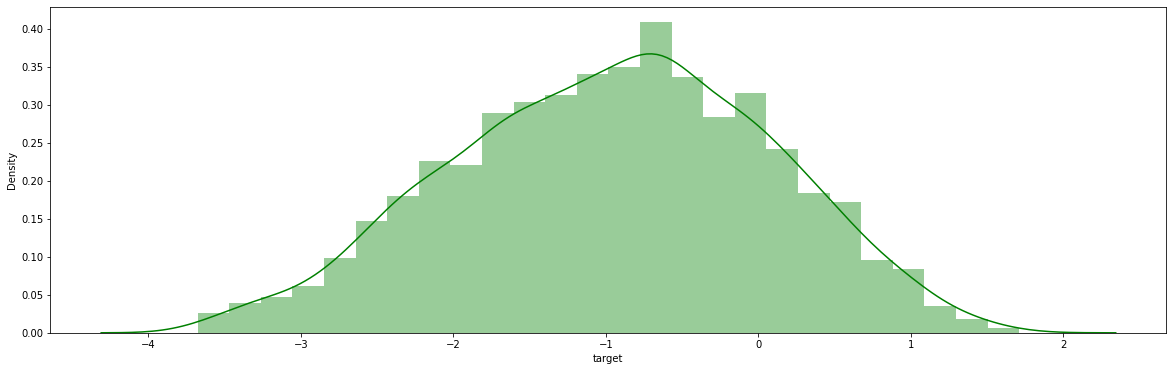

In [10]:
# Train
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(df_train['target'], ax=ax, color ='green')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


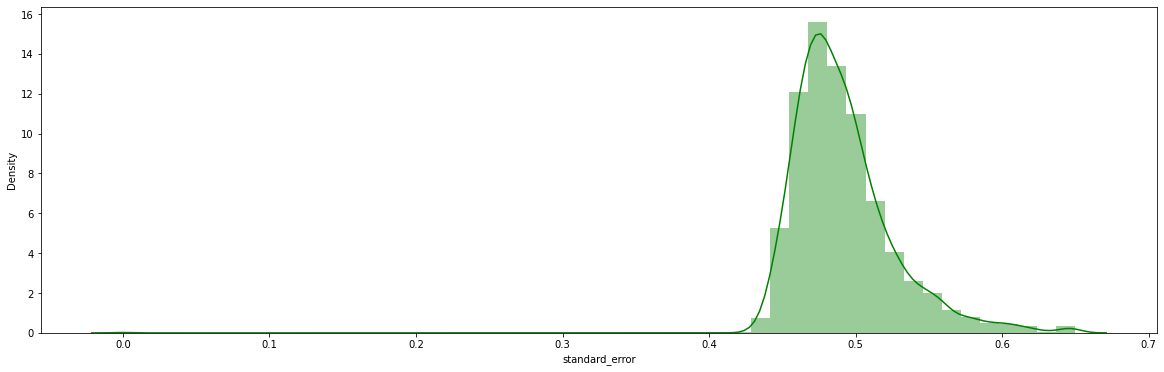

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(df_train['standard_error'], ax=ax, color ='green')
plt.show()

### Lets Find Length of the excerpt column and Count of number of words in the excerpt column

In [12]:
df_train['excerpt_len'] = df_train['excerpt'].apply(
    lambda x : len(x)
)
df_train['excerpt_word_count'] = df_train['excerpt'].apply(
    lambda x : len(x.split(' '))
)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


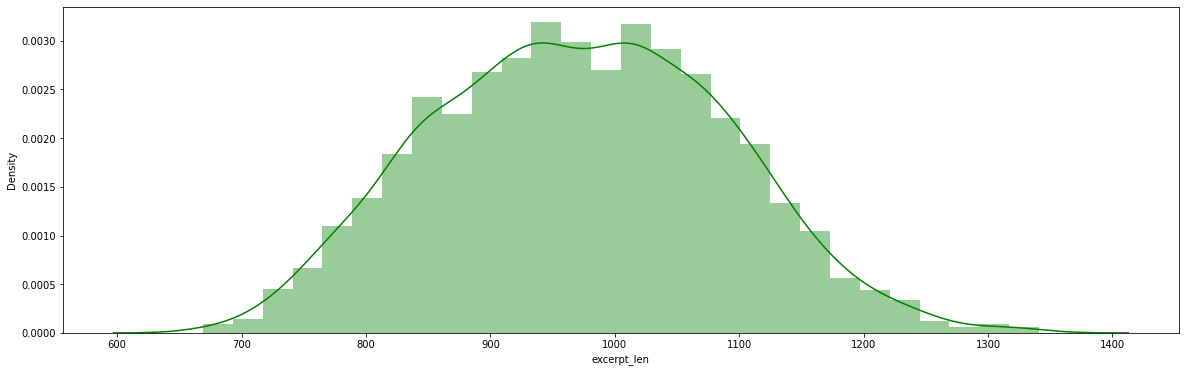

In [13]:
# Train
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(df_train['excerpt_len'], ax=ax, color ='green')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


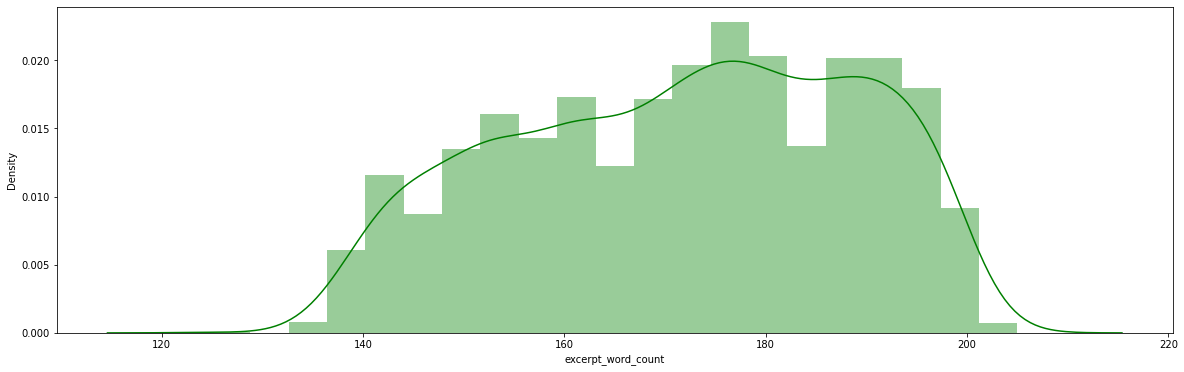

In [14]:
# Train
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(df_train['excerpt_word_count'], ax=ax, color ='green')
plt.show()

#### Vocabulary and its frequency before performing and data preprocessing 

In [15]:
results = Counter()
df_train['excerpt'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

51038


In [16]:
Word_Freq=df_train.excerpt.str.split(expand=True).stack().value_counts().reset_index()

In [17]:
Word_Freq.to_csv('Train_Word_Freq.csv',index=False)

In [18]:
Word_Freq_Test=df_test.excerpt.str.split(expand=True).stack().value_counts().reset_index()

In [19]:
df_test

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at ..."
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,Milka and John are playing in the garden. Her ...


In [20]:
Word_Freq_Test['index']

0            the
1            and
2             to
3              a
4             of
         ...    
621        hear.
622         fees
623       asking
624    operation
625        Katie
Name: index, Length: 626, dtype: object

In [21]:
common_Words=list(set(Word_Freq_Test['index']) & set(Word_Freq['index']))

In [22]:
len(common_Words)

533

### Top N-Grams and Visualization

In [23]:
def get_top_n_words(corpus, n = None):
    """
    A function that returns the top 'n' unigrams used in the corpus
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus) 
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] 
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return freq_sorted[:n]

def get_top_n_bigram(corpus, n = None):
    """
    A function that returns the top 'n' bigrams used in the corpus
    """
    vec = CountVectorizer(ngram_range = (2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return freq_sorted[:n]

def get_top_n_trigram(corpus, n = None):
    """
    A function that returns the top 'n' bigrams used in the corpus
    """
    vec = CountVectorizer(ngram_range = (3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return freq_sorted[:n]

In [24]:
top_unigram = get_top_n_words(df_train['excerpt'], 20)
words = [i[0] for i in top_unigram]
count = [i[1] for i in top_unigram]
source = ColumnDataSource(data = dict(Word = words, counts = count, color = ['#6baed6'] * 20))

p = figure(x_range = words, plot_height = 400, plot_width = 800, title = "Top Unigrams", tools = "hover", tooltips = "@Word: @counts")
p.vbar(x = 'Word', top = 'counts', width = 0.8, source = source, color = 'color')
curdoc().theme = 'dark_minimal'
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.title.align = 'center'
p.xaxis.major_label_orientation = "vertical"
show(p)

In [25]:
top_bigram = get_top_n_bigram(df_train['excerpt'], 20)
words = [i[0] for i in top_bigram]
count = [i[1] for i in top_bigram]
source = ColumnDataSource(data = dict(Word = words, counts = count, color = ['#a1dab4'] * 20))

p1 = figure(x_range = words, plot_height = 400, plot_width = 800, title = "Top Bigrams", tools = "hover", tooltips = "@Word: @counts")
p1.vbar(x = 'Word', top = 'counts', width = 0.8, source = source, color = 'color')
# curdoc().theme = 'dark_minimal'
p1.xgrid.grid_line_color = None
p1.title.align = 'center'
p1.y_range.start = 0
p1.xaxis.major_label_orientation = "vertical"
show(p1)

In [26]:
top_bigram = get_top_n_trigram(df_train['excerpt'], 20)
words = [i[0] for i in top_bigram]
count = [i[1] for i in top_bigram]
source = ColumnDataSource(data = dict(Word = words, counts = count, color = ['#a1dab4'] * 20))

p1 = figure(x_range = words, plot_height = 400, plot_width = 800, title = "Top Bigrams", tools = "hover", tooltips = "@Word: @counts")
p1.vbar(x = 'Word', top = 'counts', width = 0.8, source = source, color = 'color')
# curdoc().theme = 'dark_minimal'
p1.xgrid.grid_line_color = None
p1.title.align = 'center'
p1.y_range.start = 0
p1.xaxis.major_label_orientation = "vertical"
show(p1)

We can see from the plots we have so many unwanted tokens. We need to remove them and clean the data

## Data Preprocessing

Data preprocessing is the process of converting raw data into a well-readable format to be used by a machine learning model.

### Data Cleaning
Here We will be doing list of things:
* Stop Word Removal: While doing Vectorization, we assign some number or we transform it into a vector, extremely common words like ‘the’, ‘and’, etc. will become very important features while they add little meaning to the text. Your model can often be improved if you don’t take those words into account. Stop words are just a list of words you don’t want to use as features. 
* Punctuation Removal
* URL/ Links Removal
* Removal of Numbers 
* Non- Ascii Characters removal
* Lemmatization

In [27]:
def removeStopwords(text):
    doc = nlp(text)
    clean_text = ' '
    for txt in doc:
        if (txt.is_stop == False):
            clean_text = clean_text + " " + str(txt)        
    
    return clean_text

print("\033[1mText before removeStopwords function: \033[0m" + df_train['excerpt'][20])
print("\033[1mText after removeStopwords function: \033[0m" + removeStopwords(df_train['excerpt'][20]))

Text before removeStopwords function: Then the man took off his hat and walked away, and Philip and his sister went home. She seemed different, somehow, and he was sent to bed a little earlier than usual, but he could not go to sleep for a long time, because he heard the front-door bell ring and afterwards a man's voice and Helen's going on and on in the little drawing-room under the room which was his bedroom. He went to sleep at last, and when he woke up in the morning it was raining, and the sky was grey and miserable. He lost his collar-stud, he tore one of his stockings as he pulled it on, he pinched his finger in the door, and he dropped his tooth-mug, with water in it too, and the mug was broken and the water went into his boots. There are mornings, you know, when things happen like that. This was one of them.
Text after removeStopwords function:   man took hat walked away , Philip sister went home . different , , sent bed little earlier usual , sleep long time , heard - door be

In [28]:
def removePunctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

print("\033[1mText before removePunctuations function: \033[0m" + df_train['excerpt'][20])
print("\n")
print("\033[1mText after removePunctuations function: \033[0m" + removePunctuations(df_train['excerpt'][20]))

Text before removePunctuations function: Then the man took off his hat and walked away, and Philip and his sister went home. She seemed different, somehow, and he was sent to bed a little earlier than usual, but he could not go to sleep for a long time, because he heard the front-door bell ring and afterwards a man's voice and Helen's going on and on in the little drawing-room under the room which was his bedroom. He went to sleep at last, and when he woke up in the morning it was raining, and the sky was grey and miserable. He lost his collar-stud, he tore one of his stockings as he pulled it on, he pinched his finger in the door, and he dropped his tooth-mug, with water in it too, and the mug was broken and the water went into his boots. There are mornings, you know, when things happen like that. This was one of them.


Text after removePunctuations function: Then the man took off his hat and walked away and Philip and his sister went home She seemed different somehow and he was sent

In [29]:
def removeLinks(text):
    clean_text = re.sub('https?://\S+|www\.\S+', '', text)
    #https? will match both http and https
    #A|B, where A and B can be arbitrary REs, creates a regular expression that will match either A or B.
    #\S Matches any character which is not a whitespace character.
    #+ Causes the resulting RE to match 1 or more repetitions of the preceding RE. ab+ will match ‘a’ followed by any non-zero number of ‘b’s; it will not match just ‘a’.
    return clean_text

In [30]:
def removeNumbers(text):
    clean_text = re.sub(r'\d+', '', text)
    return clean_text

test_string = "CR 7"
(test_string,removeNumbers(test_string))

('CR 7', 'CR ')

In [31]:
def clean(text):
    text = text.lower() #Lets make it lowercase
    text = removeStopwords(text)
    text = removePunctuations(text)
    text = removeNumbers(text)
    text = removeLinks(text)
    return text

In [32]:
df_train['excerpt_clean'] = df_train['excerpt'].apply(clean)
df_test['excerpt_clean'] = df_test['excerpt'].apply(clean)

df_train['excerpt_clean'] = df_train['excerpt_clean'].str.encode('ascii', 'ignore').str.decode('ascii')
df_test['excerpt_clean'] = df_test['excerpt_clean'].str.encode('ascii', 'ignore').str.decode('ascii')

df_train.head()

,id,url_legal,license,excerpt,target,standard_error,excerpt_len,excerpt_word_count,excerpt_clean
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,992,174,young people returned ballroom presented de...
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,937,164,dinner time mrs fayre somewhat silent eye...
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,908,162,roger predicted snow departed quickly came ...
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,909,163,outside palace great garden walled round fi...
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,723,147,time bears lived house wood little small ...


In [33]:
df_train.head()

,id,url_legal,license,excerpt,target,standard_error,excerpt_len,excerpt_word_count,excerpt_clean
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,992,174,young people returned ballroom presented de...
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,937,164,dinner time mrs fayre somewhat silent eye...
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,908,162,roger predicted snow departed quickly came ...
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,909,163,outside palace great garden walled round fi...
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,723,147,time bears lived house wood little small ...


In [34]:
results = Counter()
df_train['excerpt_clean'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

26120


In [35]:
top_unigram = get_top_n_words(df_train['excerpt_clean'], 20)
words = [i[0] for i in top_unigram]
count = [i[1] for i in top_unigram]
source = ColumnDataSource(data = dict(Word = words, counts = count, color = ['#6baed6'] * 20))

p = figure(x_range = words, plot_height = 400, plot_width = 800, title = "Top Unigrams", tools = "hover", tooltips = "@Word: @counts")
p.vbar(x = 'Word', top = 'counts', width = 0.8, source = source, color = 'color')
curdoc().theme = 'dark_minimal'
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.title.align = 'center'
p.xaxis.major_label_orientation = "vertical"
show(p)

In [36]:
top_bigram = get_top_n_bigram(df_train['excerpt_clean'], 20)
words = [i[0] for i in top_bigram]
count = [i[1] for i in top_bigram]
source = ColumnDataSource(data = dict(Word = words, counts = count, color = ['#a1dab4'] * 20))

p1 = figure(x_range = words, plot_height = 400, plot_width = 800, title = "Top Bigrams", tools = "hover", tooltips = "@Word: @counts")
p1.vbar(x = 'Word', top = 'counts', width = 0.8, source = source, color = 'color')
# curdoc().theme = 'dark_minimal'
p1.xgrid.grid_line_color = None
p1.title.align = 'center'
p1.y_range.start = 0
p1.xaxis.major_label_orientation = "vertical"
show(p1)

In [37]:
top_bigram = get_top_n_trigram(df_train['excerpt_clean'], 20)
words = [i[0] for i in top_bigram]
count = [i[1] for i in top_bigram]
source = ColumnDataSource(data = dict(Word = words, counts = count, color = ['#a1dab4'] * 20))

p1 = figure(x_range = words, plot_height = 400, plot_width = 800, title = "Top Bigrams", tools = "hover", tooltips = "@Word: @counts")
p1.vbar(x = 'Word', top = 'counts', width = 0.8, source = source, color = 'color')
# curdoc().theme = 'dark_minimal'
p1.xgrid.grid_line_color = None
p1.title.align = 'center'
p1.y_range.start = 0
p1.xaxis.major_label_orientation = "vertical"
show(p1)

### Stemming

In [38]:
stemmer = SnowballStemmer(language='english')

tokens = df_train['excerpt'][1].split()
clean_text = ' '

for token in tokens:
    print(token + ' --> ' + stemmer.stem(token))

All --> all
through --> through
dinner --> dinner
time, --> time,
Mrs. --> mrs.
Fayre --> fayr
was --> was
somewhat --> somewhat
silent, --> silent,
her --> her
eyes --> eye
resting --> rest
on --> on
Dolly --> dolli
with --> with
a --> a
wistful, --> wistful,
uncertain --> uncertain
expression. --> expression.
She --> she
wanted --> want
to --> to
give --> give
the --> the
child --> child
the --> the
pleasure --> pleasur
she --> she
craved, --> craved,
but --> but
she --> she
had --> had
hard --> hard
work --> work
to --> to
bring --> bring
herself --> herself
to --> to
the --> the
point --> point
of --> of
overcoming --> overcom
her --> her
own --> own
objections. --> objections.
At --> at
last, --> last,
however, --> however,
when --> when
the --> the
meal --> meal
was --> was
nearly --> near
over, --> over,
she --> she
smiled --> smile
at --> at
her --> her
little --> littl
daughter, --> daughter,
and --> and
said, --> said,
"All --> "all
right, --> right,
Dolly, --> dolly,
you -->

In [39]:
def stemWord(text):
    stemmer = SnowballStemmer(language='english')
    tokens = text.split()
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + stemmer.stem(token)      
    
    return clean_text

print("\033[1mText before stemWord function: \033[0m" + df_train['excerpt'][1])
print("\033[1mText after stemWord function: \033[0m" + stemWord(df_train['excerpt'][1]))

Text before stemWord function: All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the child the pleasure she craved, but she had hard work to bring herself to the point of overcoming her own objections.
At last, however, when the meal was nearly over, she smiled at her little daughter, and said, "All right, Dolly, you may go."
"Oh, mother!" Dolly cried, overwhelmed with sudden delight. "Really?
Oh, I am so glad! Are you sure you're willing?"
"I've persuaded myself to be willing, against my will," returned Mrs. Fayre, whimsically. "I confess I just hate to have you go, but I can't bear to deprive you of the pleasure trip. And, as you say, it would also keep Dotty at home, and so, altogether, I think I shall have to give in."
"Oh, you angel mother! You blessed lady! How good you are!" And Dolly flew around the table and gave her mother a hug that nearly suffocated her.
Text after stemWord function:  

In [40]:
df_train['excerpt_clean_Stem'] = df_train['excerpt_clean'].apply(stemWord)
df_test['excerpt_clean_Stem'] = df_test['excerpt_clean'].apply(stemWord)

#### Lemmatization

In [41]:
def lemmatizeWord(text):
    tokens=nlp(text)
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + token.lemma_      
    
    return clean_text

In [42]:
df_train['excerpt_clean_Lemm'] = df_train['excerpt_clean'].apply(lemmatizeWord)
df_test['excerpt_clean_Lemm'] = df_test['excerpt_clean'].apply(lemmatizeWord)

In [43]:
results = Counter()
df_train['excerpt_clean'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

26120


In [44]:
results = Counter()
df_train['excerpt_clean_Lemm'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

20342


In [45]:
results = Counter()
df_train['excerpt_clean_Stem'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

16625


# Text Vectorization
* Bag of Words (BoW)
* TD IDF
* Embeddings

## Bag of Words
A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

A vocabulary of known words.
A measure of the presence of known words. It is called a “bag” of words, because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.
An n-gram is a contiguous sequence of n items from a given sample of text or speech

An n-gram of size 1 is referred to as a "unigram"; size 2 is a "bigram" (or, less commonly, a "digram"); size 3 is a "trigram".

## Machine Learning
### Unigram

In [46]:
rmse = lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred))
rmse_loss = lambda Estimator, X, y: rmse(y, Estimator.predict(X))

In [47]:
# Split into train and test sets


x = df_train['excerpt_clean']
y = df_train['target']

print(len(x), len(y))

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

2834 2834
2125 2125
709 709


In [48]:
# Split into train and test sets


x_Lemm = df_train['excerpt_clean_Lemm']
y_Lemm = df_train['target']

print(len(x_Lemm), len(y_Lemm))

x_train_Lemm, x_test_Lemm, y_train_Lemm, y_test_Lemm = train_test_split(x_Lemm, y_Lemm, random_state=42)
print(len(x_train_Lemm), len(y_train_Lemm))
print(len(x_test_Lemm), len(y_test_Lemm))

2834 2834
2125 2125
709 709


In [49]:
# Split into train and test sets


x_Stem = df_train['excerpt_clean_Stem']
y_Stem = df_train['target']

print(len(x_Stem), len(y_Stem))

x_train_Stem, x_test_Stem, y_train_Stem, y_test_Stem = train_test_split(x_Stem, y_Stem, random_state=42)
print(len(x_train_Stem), len(y_train_Stem))
print(len(x_test_Stem), len(y_test_Stem))

2834 2834
2125 2125
709 709


In [50]:
x

0         young people returned ballroom  presented de...
1         dinner time  mrs  fayre somewhat silent  eye...
2         roger predicted  snow departed quickly came ...
3         outside palace great garden walled round  fi...
4         time bears lived house wood  little  small  ...
                              ...                        
2829      think dinosaurs lived  picture  hot  steamy ...
2830      solid  solids usually hard molecules packed ...
2831      second state matter discuss liquid  solids h...
2832      solids shapes actually touch  dimensions  me...
2833      animals cells  eat things digest inside  ani...
Name: excerpt_clean, Length: 2834, dtype: object

In [51]:
model = make_pipeline(
    CountVectorizer(ngram_range=(1,1)),
    LinearRegression(),
)

model.fit(x_train,y_train)

val_score = cross_val_score(
    model, 
    x_test, 
    y_test, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,1): {val_score}')

Validation Score for CountVectorizer(1,1): 0.8173723680563298


In [52]:
test_predict=model.predict(df_test['excerpt_clean'])

In [53]:
test_predict

array([-2.0930562 , -0.45901579, -0.59291768, -1.632414  , -1.26831063,
       -0.80590504,  0.2291972 ])

In [54]:
df_test

,id,url_legal,license,excerpt,excerpt_clean,excerpt_clean_Stem,excerpt_clean_Lemm
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...,hope lay jack promise bright light burning u...,hope lay jack promis bright light burn upper...,hope lay jack promise bright light burn u...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...,dotty continued mrs gray night milk katie ...,dotti continu mrs gray night milk kati went ...,dotty continue mrs gray night milk ka...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...,bright cheerful scene greeted eyes captain r...,bright cheer scene greet eye captain raymond...,bright cheerful scene greet eye captain r...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...,cell division process parent cell divides da...,cell divis process parent cell divid daughte...,cell division process parent cell divide ...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...,debugging process finding resolving defects ...,debug process find resolv defect prevent cor...,debugging process find resolve defect pre...
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at ...",explain transitivity let look totally diffe...,explain transit let look total differ exampl...,explain transitivity let look totally d...
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,Milka and John are playing in the garden. Her ...,milka john playing garden little sister pla...,milka john play garden littl sister play mil...,milka john play garden little sister pl...


In [55]:
df_submission['target']=test_predict

In [56]:
df_submission.to_csv('submission.csv',index=False)

### Bigram

In [57]:
model = make_pipeline(
    CountVectorizer(ngram_range=(2,2)),
    LinearRegression(),
)

model.fit(x_train,y_train)

val_score = cross_val_score(
    model, 
    x_test, 
    y_test, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(2,2): {val_score}')

model_Stem = make_pipeline(
    CountVectorizer(ngram_range=(2,2)),
    LinearRegression(),
)

model_Stem.fit(x_train_Stem,y_train_Stem)

val_score_Stem = cross_val_score(
    model, 
    x_test_Stem, 
    y_test_Stem, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(2,2): {val_score_Stem}')

model_Lemm = make_pipeline(
    CountVectorizer(ngram_range=(2,2)),
    LinearRegression(),
)

model_Lemm.fit(x_train_Lemm,y_train_Lemm)

val_score_Lemm = cross_val_score(
    model, 
    x_test_Lemm, 
    y_test_Lemm, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(2,2): {val_score_Lemm}')

Validation Score for CountVectorizer(2,2): 1.0042532166501597
Validation Score for CountVectorizer(2,2): 0.9986069671073154
Validation Score for CountVectorizer(2,2): 0.9951409121688082


### Trigram

In [58]:
model = make_pipeline(
    CountVectorizer(ngram_range=(3,3)),
    LinearRegression(),
)

model.fit(x_train,y_train)

val_score = cross_val_score(
    model, 
    x_test, 
    y_test, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(3,3): {val_score}')

model_Stem = make_pipeline(
    CountVectorizer(ngram_range=(3,3)),
    LinearRegression(),
)

model_Stem.fit(x_train_Stem,y_train_Stem)

val_score_Stem = cross_val_score(
    model, 
    x_test_Stem, 
    y_test_Stem, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(3,3): {val_score_Stem}')

model_Lemm = make_pipeline(
    CountVectorizer(ngram_range=(3,3)),
    LinearRegression(),
)

model_Lemm.fit(x_train_Lemm,y_train_Lemm)

val_score_Lemm = cross_val_score(
    model, 
    x_test_Lemm, 
    y_test_Lemm, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(3,3): {val_score_Lemm}')

Validation Score for CountVectorizer(3,3): 1.0266762588997191
Validation Score for CountVectorizer(3,3): 1.026621647436598
Validation Score for CountVectorizer(3,3): 1.026378372109817


# Uni + Bi-Gram

In [59]:
model = make_pipeline(
    CountVectorizer(ngram_range=(1,2)),
    LinearRegression(),
)

model.fit(x_train,y_train)

val_score = cross_val_score(
    model, 
    x_test, 
    y_test, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,2): {val_score}')

model_Stem = make_pipeline(
    CountVectorizer(ngram_range=(1,2)),
    LinearRegression(),
)

model_Stem.fit(x_train_Stem,y_train_Stem)

val_score_Stem = cross_val_score(
    model, 
    x_test_Stem, 
    y_test_Stem, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,2): {val_score_Stem}')

model_Lemm = make_pipeline(
    CountVectorizer(ngram_range=(1,2)),
    LinearRegression(),
)

model_Lemm.fit(x_train_Lemm,y_train_Lemm)

val_score_Lemm = cross_val_score(
    model, 
    x_test_Lemm, 
    y_test_Lemm, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,2): {val_score_Lemm}')

Validation Score for CountVectorizer(1,2): 0.8183749611703135
Validation Score for CountVectorizer(1,2): 0.8094100774242724
Validation Score for CountVectorizer(1,2): 0.8060286864864352


### 1+2+3-Gram

In [60]:
model = make_pipeline(
    CountVectorizer(ngram_range=(1,3)),
    LinearRegression(),
)

model.fit(x_train,y_train)

val_score = cross_val_score(
    model, 
    x_test, 
    y_test, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,3): {val_score}')

model_Stem = make_pipeline(
    CountVectorizer(ngram_range=(1,3)),
    LinearRegression(),
)

model_Stem.fit(x_train_Stem,y_train_Stem)

val_score_Stem = cross_val_score(
    model, 
    x_test_Stem, 
    y_test_Stem, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,3): {val_score_Stem}')

model_Lemm = make_pipeline(
    CountVectorizer(ngram_range=(1,3)),
    LinearRegression(),
)

model_Lemm.fit(x_train_Lemm,y_train_Lemm)

val_score_Lemm = cross_val_score(
    model, 
    x_test_Lemm, 
    y_test_Lemm, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,3): {val_score_Lemm}')

Validation Score for CountVectorizer(1,3): 0.8326488354410765
Validation Score for CountVectorizer(1,3): 0.819563715591015
Validation Score for CountVectorizer(1,3): 0.815442972273687


### Bi-Gram + Tri-Gram

In [61]:
model = make_pipeline(
    CountVectorizer(ngram_range=(2,3)),
    LinearRegression(),
)

model.fit(x_train,y_train)

val_score = cross_val_score(
    model, 
    x_test, 
    y_test, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(2,3): {val_score}')

model_Stem = make_pipeline(
    CountVectorizer(ngram_range=(2,3)),
    LinearRegression(),
)

model_Stem.fit(x_train_Stem,y_train_Stem)

val_score_Stem = cross_val_score(
    model, 
    x_test_Stem, 
    y_test_Stem, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(2,3): {val_score_Stem}')

model_Lemm = make_pipeline(
    CountVectorizer(ngram_range=(2,3)),
    LinearRegression(),
)

model_Lemm.fit(x_train_Lemm,y_train_Lemm)

val_score_Lemm = cross_val_score(
    model, 
    x_test_Lemm, 
    y_test_Lemm, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(2,3): {val_score_Lemm}')

Validation Score for CountVectorizer(2,3): 1.0138428926543201
Validation Score for CountVectorizer(2,3): 1.0106584853241898
Validation Score for CountVectorizer(2,3): 1.0085349377242465


## XGBoost

In [62]:
model = make_pipeline(
    CountVectorizer(ngram_range=(1,1)),
    xgb.XGBRegressor() ,
)

model.fit(x_train,y_train)

val_score = cross_val_score(
    model, 
    x_test, 
    y_test, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,1): {val_score}')

model = make_pipeline(
    CountVectorizer(ngram_range=(1,1)),
    xgb.XGBRegressor() ,
)

model.fit(x_train_Stem,y_train_Stem)

val_score = cross_val_score(
    model, 
    x_test_Stem, 
    y_test_Stem, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,1): {val_score}')

model = make_pipeline(
    CountVectorizer(ngram_range=(1,1)),
    xgb.XGBRegressor() ,
)

model.fit(x_train_Lemm,y_train_Lemm)

val_score = cross_val_score(
    model, 
    x_test_Lemm, 
    y_test_Lemm, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,1): {val_score}')

Validation Score for CountVectorizer(1,1): 0.9029546016387293
Validation Score for CountVectorizer(1,1): 0.9106696759986457
Validation Score for CountVectorizer(1,1): 0.8931722726562956


In [63]:
model = make_pipeline(
    CountVectorizer(ngram_range=(1,2)),
    xgb.XGBRegressor() ,
)

model.fit(x_train,y_train)

val_score = cross_val_score(
    model, 
    x_test, 
    y_test, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,2): {val_score}')

model = make_pipeline(
    CountVectorizer(ngram_range=(1,2)),
    xgb.XGBRegressor() ,
)

model.fit(x_train_Stem,y_train_Stem)

val_score = cross_val_score(
    model, 
    x_test_Stem, 
    y_test_Stem, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,2): {val_score}')

model = make_pipeline(
    CountVectorizer(ngram_range=(1,2)),
    xgb.XGBRegressor() ,
)

model.fit(x_train_Lemm,y_train_Lemm)

val_score = cross_val_score(
    model, 
    x_test_Lemm, 
    y_test_Lemm, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,2): {val_score}')

Validation Score for CountVectorizer(1,2): 0.9010397960902132
Validation Score for CountVectorizer(1,2): 0.9019893714349505
Validation Score for CountVectorizer(1,2): 0.8869524412462099


In [64]:
model = make_pipeline(
    CountVectorizer(ngram_range=(1,3)),
    xgb.XGBRegressor() ,
)

model.fit(x_train,y_train)

val_score = cross_val_score(
    model, 
    x_test, 
    y_test, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,3): {val_score}')

model = make_pipeline(
    CountVectorizer(ngram_range=(1,3)),
    xgb.XGBRegressor() ,
)

model.fit(x_train_Stem,y_train_Stem)

val_score = cross_val_score(
    model, 
    x_test_Stem, 
    y_test_Stem, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,3): {val_score}')

model = make_pipeline(
    CountVectorizer(ngram_range=(1,3)),
    xgb.XGBRegressor() ,
)

model.fit(x_train_Lemm,y_train_Lemm)

val_score = cross_val_score(
    model, 
    x_test_Lemm, 
    y_test_Lemm, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(1,3): {val_score}')

Validation Score for CountVectorizer(1,3): 0.9010397960902132
Validation Score for CountVectorizer(1,3): 0.905777775690729
Validation Score for CountVectorizer(1,3): 0.8835930243872518


In [65]:
model = make_pipeline(
    CountVectorizer(ngram_range=(2,3)),
    xgb.XGBRegressor() ,
)

model.fit(x_train,y_train)

val_score = cross_val_score(
    model, 
    x_test, 
    y_test, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(2,3): {val_score}')

model = make_pipeline(
    CountVectorizer(ngram_range=(2,3)),
    xgb.XGBRegressor() ,
)

model.fit(x_train_Stem,y_train_Stem)

val_score = cross_val_score(
    model, 
    x_test_Stem, 
    y_test_Stem, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(2,3): {val_score}')

model = make_pipeline(
    CountVectorizer(ngram_range=(2,3)),
    xgb.XGBRegressor() ,
)

model.fit(x_train_Lemm,y_train_Lemm)

val_score = cross_val_score(
    model, 
    x_test_Lemm, 
    y_test_Lemm, 
    scoring=rmse_loss
).mean()

print(f'Validation Score for CountVectorizer(2,3): {val_score}')

Validation Score for CountVectorizer(2,3): 1.0011173546547472
Validation Score for CountVectorizer(2,3): 1.0057362734517235
Validation Score for CountVectorizer(2,3): 0.9997696362894972


In [66]:
def training_BOW(X_train, y_train, X_test, y_test, model_name, m,n):
    t1 = time.time()
    
    model = make_pipeline(CountVectorizer(ngram_range=(m,n)),model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mse(y_test, y_pred)
    rmse =np.sqrt(MSE)
    t2 = time.time()
    training_time = t2-t1 
    
    print("--- Model:", model_name,"---")
    print("MSE: ",MSE)
    print("RMSE: ",rmse)
    print("Training time:",training_time)
    print("\n")

In [67]:
training_BOW(x_train_Lemm,y_train_Lemm,x_test_Lemm,y_test_Lemm,xgb.XGBRegressor(),1,2)

--- Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) ---
MSE:  0.7309346420970678
RMSE:  0.8549471574881502
Training time: 12.662652254104614




In [68]:
training_BOW(x_train_Lemm,y_train_Lemm,x_test_Lemm,y_test_Lemm,xgb.XGBRegressor(),1,1)

--- Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) ---
MSE:  0.7130190501809234
RMSE:  0.8444045536239861
Training time: 2.475881576538086




In [69]:
training_BOW(x_train_Lemm,y_train_Lemm,x_test_Lemm,y_test_Lemm,xgb.XGBRegressor(),1,3)

--- Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) ---
MSE:  0.7309346420970678
RMSE:  0.8549471574881502
Training time: 24.8683180809021




### TF-IDF

TF-IDF (stands for Term-Frequency-Inverse-Document Frequency) weights down the common words occuring in almost all the documents and give more importance to the words that appear in a subset of documents. TF-IDF works by penalising these common words by assigning them lower weights while giving importance to some rare words in a particular document.

In [70]:
def training_TFIDF(X_train, y_train, X_test, y_test, model_name,ngram_range):
    t1 = time.time()
    
    model = make_pipeline(TfidfVectorizer(binary=True, ngram_range=ngram_range),model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mse(y_test, y_pred)
    rmse =np.sqrt(MSE)
    t2 = time.time()
    training_time = t2-t1 
    
    print("--- Model:", model_name,"---")
    print("MSE: ",MSE)
    print("RMSE: ",rmse)
    print("Training time:",training_time)
    print("\n")

In [71]:
n_gram_dict = { "Unigram" : (1,1), "Unigrams + Bigrams": (1,2), "Bigrams alone": (2,2), "Unigrams + Bigrams + Trigrams": (1,3)}

In [72]:
training_TFIDF(x_train_Lemm,y_train_Lemm,x_test_Lemm,y_test_Lemm,xgb.XGBRegressor(),n_gram_dict['Unigram'])

--- Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) ---
MSE:  0.6966933862735438
RMSE:  0.8346816077244926
Training time: 5.982913494110107




In [73]:
training_TFIDF(x_train_Lemm,y_train_Lemm,x_test_Lemm,y_test_Lemm,LinearRegression(),n_gram_dict['Unigram'])

--- Model: LinearRegression() ---
MSE:  0.5828298847945201
RMSE:  0.7634329602489797
Training time: 0.38117337226867676




In [74]:
training_TFIDF(x_train_Lemm,y_train_Lemm,x_test_Lemm,y_test_Lemm,xgb.XGBRegressor(),n_gram_dict['Unigrams + Bigrams'])

--- Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) ---
MSE:  1.2199943284822057
RMSE:  1.1045335343402687
Training time: 16.37947177886963




In [75]:
training_TFIDF(x_train_Lemm,y_train_Lemm,x_test_Lemm,y_test_Lemm,LinearRegression(),n_gram_dict['Unigrams + Bigrams'])

--- Model: LinearRegression() ---
MSE:  0.5822119784654964
RMSE:  0.7630281636122591
Training time: 1.0428550243377686




In [76]:
training_TFIDF(x_train_Lemm,y_train_Lemm,x_test_Lemm,y_test_Lemm,xgb.XGBRegressor(),n_gram_dict['Bigrams alone'])

--- Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) ---
MSE:  0.9649966309794689
RMSE:  0.9823424204316278
Training time: 10.669255018234253




In [77]:
training_TFIDF(x_train_Lemm,y_train_Lemm,x_test_Lemm,y_test_Lemm,LinearRegression(),n_gram_dict['Bigrams alone'])

--- Model: LinearRegression() ---
MSE:  0.7967006902504944
RMSE:  0.8925809152398982
Training time: 0.8773031234741211




In [78]:
training_TFIDF(x_train_Lemm,y_train_Lemm,x_test_Lemm,y_test_Lemm,xgb.XGBRegressor(),n_gram_dict['Unigrams + Bigrams + Trigrams'])

--- Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) ---
MSE:  1.0830714727980468
RMSE:  1.040707198398304
Training time: 29.82624340057373




In [79]:
training_TFIDF(x_train_Lemm,y_train_Lemm,x_test_Lemm,y_test_Lemm,LinearRegression(),n_gram_dict['Unigrams + Bigrams + Trigrams'])

--- Model: LinearRegression() ---
MSE:  0.6460241017044754
RMSE:  0.8037562452040267
Training time: 1.9826443195343018




### Deep Learning
#### Keras

In [80]:
x_train_Lemm.shape[0]

2125

In [81]:
from keras.models import Sequential
from keras import layers

#input_dim = x_train_Lemm.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=1, activation='relu'))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [82]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=26118)
tokenizer.fit_on_texts(df_train['excerpt_clean_Lemm'].to_list())

X_train = tokenizer.texts_to_sequences(df_train['excerpt_clean_Lemm'].to_list())
X_test = tokenizer.texts_to_sequences(df_test['excerpt_clean_Lemm'].to_list())

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(df_train['excerpt_clean_Lemm'][2])
print(X_train[2])

     roger predict   snow depart quickly come   day sleigh ride scarcely vestige white ground   tennis possible great game progress court pine laurel   patty roger play elise sam blaney   pair match  
  long   contest victory finally go patty   laughingly accept defeat  
   patty game    roger defend    child sick list   know   sam   mark   
    like    cry patty    suppose bear half blame   roger    mr   blaney   absorb love game   play old   time skill   
   right   patsy   let     suddenly remember mona tell tell   affected service  
[3097, 2113, 390, 2748, 515, 1, 8, 4668, 446, 1005, 7069, 91, 196, 5992, 332, 10, 391, 1230, 902, 1300, 8846, 2452, 3097, 61, 11746, 1473, 8847, 827, 1261, 18, 3877, 1887, 613, 5, 2452, 11747, 1040, 1888, 2452, 391, 3097, 2453, 29, 768, 1474, 6, 1473, 740, 7, 123, 2452, 669, 128, 153, 2321, 3097, 115, 8847, 1301, 156, 391, 61, 15, 4, 1262, 92, 11748, 100, 348, 236, 11749, 31, 31, 7070, 550]


In [83]:
vocab_size

20343

In [84]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 800

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[   68    11   184 11740   152  4667    75  1071   483  2112  1072   358
  2915   371   209   390    91  3317   261  4262  8842  2319  7064     7
   460   390   148  1299  1618 11741  2916    71  1970  3875  4263  8843
  2043     7   390  1885   668  2320 11742  2604  1198  7065   612   573
   106    71   240   612   186   128   574  3876  3876  1886    86    38
   391    86   604   106    71    38   106    14   361   795   372   795
  1381    33    43  1419    98   135   795   431   131  3318  1811   322
 11743     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [85]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 800, 50)           1017150   
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                400010    
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,417,171
Trainable params: 1,417,171
Non-trainable params: 0
_________________________________________________________________


In [86]:
training_labels_final = np.array(df_train.target)

In [87]:
history = model.fit(X_train, training_labels_final,
                    epochs=20,
                    validation_split=0.1,
                    batch_size=32)

Epoch 1/20
80/80 [==============================] - 2s 14ms/step - loss: 2.8058 - root_mean_squared_error: 1.6204 - val_loss: 1.4290 - val_root_mean_squared_error: 1.1954
Epoch 2/20
80/80 [==============================] - 1s 7ms/step - loss: 1.4372 - root_mean_squared_error: 1.1986 - val_loss: 1.1777 - val_root_mean_squared_error: 1.0852
Epoch 3/20
80/80 [==============================] - 1s 7ms/step - loss: 1.1647 - root_mean_squared_error: 1.0788 - val_loss: 0.9312 - val_root_mean_squared_error: 0.9650
Epoch 4/20
80/80 [==============================] - 1s 7ms/step - loss: 0.8008 - root_mean_squared_error: 0.8946 - val_loss: 0.6949 - val_root_mean_squared_error: 0.8336
Epoch 5/20
80/80 [==============================] - 1s 7ms/step - loss: 0.7584 - root_mean_squared_error: 0.8696 - val_loss: 0.7235 - val_root_mean_squared_error: 0.8506
Epoch 6/20
80/80 [==============================] - 1s 7ms/step - loss: 0.6855 - root_mean_squared_error: 0.8278 - val_loss: 0.9421 - val_root_mean_s

### Glove Embeddings

What if, instead of learning the embeddings for yourself, you could instead use prelearned embeddings, where researchers have already done the hard work of turning words into vectors and those vectors are proven? One example of this is the GloVe (Global Vectors for WordRepresentation) model developed by Jeffrey Pennington, Richard Socher, and Christopher Manning at Stanford

Pretrained Word Embeddings are the embeddings learned in one task that are used for solving another similar task. These embeddings are trained on large datasets, saved, and then used for solving other tasks. That’s why pretrained word embeddings are a form of Transfer Learning.

In [88]:
#text = df_train.excerpt
text = df_train.excerpt_clean_Lemm

In [89]:
vocab_size = 26118
embedding_dim = 512
max_length = 500
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

In [90]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index

In [91]:
X_train_Seq = tokenizer.texts_to_sequences(text)
X_train = pad_sequences(X_train_Seq,maxlen=max_length, 
                                truncating=trunc_type, padding=pad_type)


In [92]:
glove_embeddings = dict()
f = open('../input/glove-global-vectors-for-word-representation/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

In [93]:
glove_embeddings['study']

array([ 0.7196   ,  0.71446  , -0.51931  , -0.7443   , -0.06024  ,
        0.54708  , -0.54618  , -0.99133  ,  0.73429  ,  0.18832  ,
        0.32969  , -0.27397  ,  0.28741  , -0.09161  ,  0.32494  ,
       -0.017665 , -0.13707  , -0.17801  , -0.24557  ,  0.11867  ,
        0.34275  ,  0.3795   ,  0.42772  , -0.26742  ,  0.37385  ,
       -1.2254   , -0.77036  , -0.70446  , -1.175    ,  0.14247  ,
        3.0784   , -0.39591  , -0.30366  , -1.7702   , -0.0043639,
       -0.46792  , -0.08895  ,  0.89358  ,  0.88059  ,  0.22266  ,
       -0.53512  , -0.49875  ,  0.61852  ,  0.69546  ,  0.39189  ,
        0.053596 ,  0.81017  ,  0.87904  , -0.37766  ,  0.46718  ],
      dtype=float32)

In [94]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(glove_embeddings[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(50)
    return v / np.sqrt((v ** 2).sum())

In [95]:
embedding_dim = 50
vocab_size = 26118

In [96]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
         break
    else:
        embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [97]:
model = tf.keras.Sequential([
 tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
 return_sequences=True)),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
 tf.keras.layers.Dense(24, activation='relu'),
 tf.keras.layers.Dense(1)
])

In [98]:
learning_rate = 0.00003
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          1305900   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 100)         40400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_4 (Dense)              (None, 24)                2424      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 1,409,149
Trainable params: 103,249
Non-trainable params: 1,305,900
_________________________________________________________________


In [99]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_root_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [100]:
num_epochs = 100
history = model.fit(X_train, training_labels_final, epochs=num_epochs, 
                    validation_split=0.3,
                    batch_size=32,callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/100
62/62 [==============================] - 13s 117ms/step - loss: 1.9032 - root_mean_squared_error: 1.3790 - val_loss: 1.2701 - val_root_mean_squared_error: 1.1270
Epoch 2/100
62/62 [==============================] - 6s 93ms/step - loss: 1.4351 - root_mean_squared_error: 1.1979 - val_loss: 1.0491 - val_root_mean_squared_error: 1.0242
Epoch 3/100
62/62 [==============================] - 6s 94ms/step - loss: 1.2655 - root_mean_squared_error: 1.1244 - val_loss: 0.9737 - val_root_mean_squared_error: 0.9868
Epoch 4/100
62/62 [==============================] - 6s 94ms/step - loss: 1.1241 - root_mean_squared_error: 1.0600 - val_loss: 0.9095 - val_root_mean_squared_error: 0.9537
Epoch 5/100
62/62 [==============================] - 6s 93ms/step - loss: 1.0399 - root_mean_squared_error: 1.0196 - val_loss: 0.8418 - val_root_mean_squared_error: 0.9175
Epoch 6/100
62/62 [==============================] - 6s 93ms/step - loss: 0.9386 - root_mean_squared_error: 0.9687 - val_loss: 0.7818 - va

In [101]:
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(df_test['excerpt'])
excerpt_padded = pad_sequences(sample_sequences, padding=padding_type, 
                             maxlen=max_length) 
values = model.predict(excerpt_padded)
submission_file= "/kaggle/input/commonlitreadabilityprize/sample_submission.csv"
sample_submission = pd.read_csv(submission_file)
sample_submission["target"] = values
sample_submission.to_csv("submission.csv", index=False)